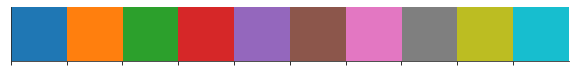

In [1]:
%load_ext autoreload
%autoreload 2
%run __init__
rs2_path = path['RSRCH'](4)

cache_path = './cache/e004'
try:
    os.mkdir(cache_path)
except:
    pass

fig_path = './figures/e004'
try:
    os.mkdir(fig_path)
except:
    pass

import importlib
e002_PLV = importlib.import_module('e002-ANK-Wavelet')
e004_NTF = importlib.import_module('e004-ANK-NTF_LDS')
e001_LL = importlib.import_module('e001-ANK-Line_Length')

stdout_orig = sys.stdout

flatui = ["#46637f", "#2ecc71", "#e74c3c", "#3498db", "#9b59b6", "#95a5a6"]
sns.palplot(sns.color_palette("tab10"))
sns.set_palette("tab10")

import statsmodels.formula.api as smf
import statsmodels
from scipy.special import expit

In [2]:
df_npref = path['CORE']['RNS']['NP_Ref']
df_ctlg = path['CORE']['RNS']['CATALOG']
TOD_DAYTIME = (7, 19)
BASELINE_DAY = 90

# Seizure Stratification Model

## Source Features

In [3]:
#####
def combine_temporal_features(np_code, despiked):
    
    ###
    key_dates = extract_key_dates(np_code)

    W_PLV, n_exclude = e002_PLV.resample_PLV(np_code, remove_blank=True, despiked=False)        
    W_PLV = pd.concat([www[1]['PLV_Intra'].to_frame(name=www[0]) for www in W_PLV.groupby(['PLV_Band'])], axis=1)
    W_PLV = np.arctanh(W_PLV)
    W_PLV = W_PLV.reset_index().rename(columns={'Raw UTC Timestamp': 'Timestamp'})

    W_LL, n_exclude = e001_LL.resample_LL(np_code, remove_blank=True)        
    W_LL = W_LL[['CoVR']].rename(columns={'CoVR': 'LL_mean'}).reset_index().rename(columns={'Raw UTC Timestamp': 'Timestamp'})

    XX = pd.merge(W_PLV, W_LL, on='Timestamp').set_index('Timestamp')
    
    # Resample temporal data
    X = XX.loc[XX.index >= key_dates[0]] 
    X = X.set_index(X.index - key_dates[0])            
    X0 = np.nan*X.iloc[[0]]
    X0.index = [pd.Timedelta('0D')]
    X1 = X0.append(X).resample('1D').mean()

    return X1

## Build Features

In [4]:
### Setup Names
despiked = False 
    
feat_dict = {'NP_code': [],
             'Months_Elapsed': [],
             
             'Theta_Slope': [],
             'Alpha_Slope': [],
             'Beta_Slope': [],
             'Broadband_Slope': [],
             'Gamma_Slope': [],
             'LowG_Slope': [],
             'HighG_Slope': [],
             'LL_mean_Slope': []}

# Iterate over NP Subjects
for np_code in df_npref['NP_code'].unique():
    print(np_code)
    
    ### Get Features
    X1 = combine_temporal_features(np_code, despiked=despiked)

    ### Iterate over months
    for month in np.arange(0, 12*5+1, 1):
        
        ### Prepare DataFrame
        X = X1[:int(month*30)].copy()
        X = X.dropna()
        if len(X) == 0:
            continue
        X = X.set_index(X.index.days).reset_index()
        X = X.rename(columns={'index': 'time'})
        
        ############################################################### 
        feat_dict['NP_code'].append(np_code)
        feat_dict['Months_Elapsed'].append(month)        

        ### Slope
        for col in ['Alpha (8-15Hz)', 'Beta (15-30Hz)', 'Broadband (4-100Hz)', 'Gamma (30-100Hz)',
                    'HighG (70-100Hz)', 'LowG (30-70Hz)', 'Theta (4-8Hz)', 'LL_mean']:
            if month < 3:
                feat_dict['{}_Slope'.format(col.split(' ')[0])].append(np.nan)
            else:
                feat_dict['{}_Slope'.format(col.split(' ')[0])].append(
                    sp_stats.linregress(X['time'], sp_stats.zscore(X[col]))[0])


### Create DataFrame
feat_dict = pd.DataFrame.from_dict(feat_dict)
feat_dict = pd.merge(feat_dict, df_npref[['NP_code', 'N_Vs_MT', 'Responder_Type', 'Pct_Seizure_Reduction_Last_Visit']], on='NP_code')

NP1
NP2
NP3
NP4
NP5
NP6
NP7
NP9
NP10
NP11
NP12
NP13
NP14
NP15
NP16
NP17
NP18
NP19
NP55
NP20
NP21
NP22
NP23
NP24
NP25
NP26
NP27
NP28
NP29
NP30
NP31
NP33
NP32
NP34
NP35
NP36
NP37
NP38
NP39
NP41
NP40
NP42
NP43
NP44
NP45
NP46
NP47
NP48
NP49
NP50
NP51


## Build Model







-------- N --------
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


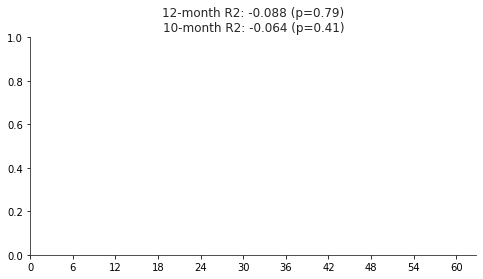

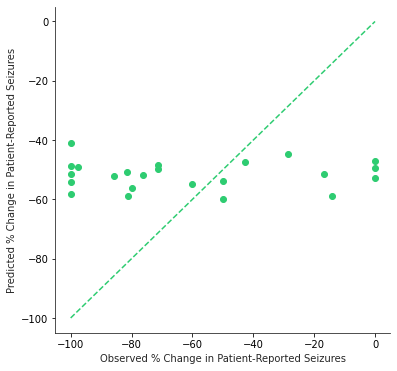

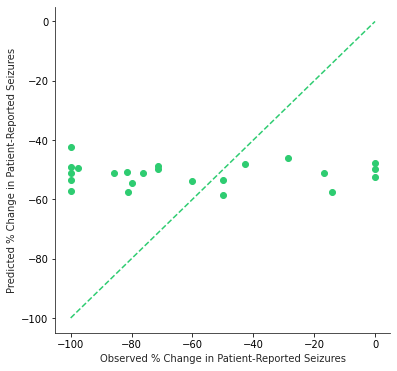

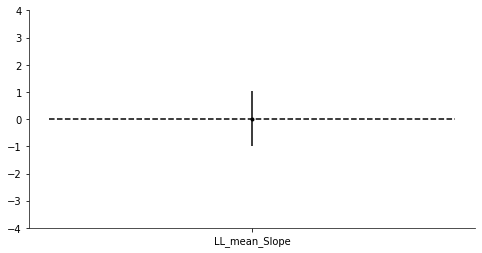

           Param         Z     p
0  LL_mean_Slope -0.023228  0.45


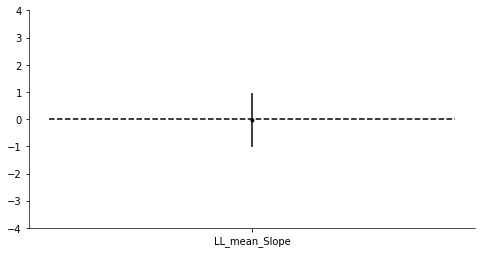

           Param         Z     p
0  LL_mean_Slope  0.037203  0.41






-------- N --------
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


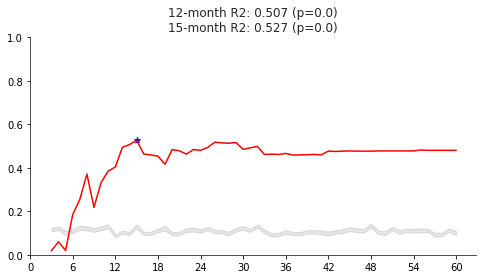

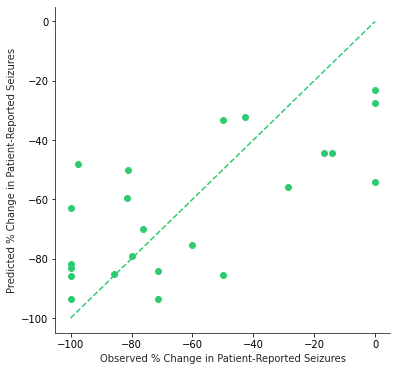

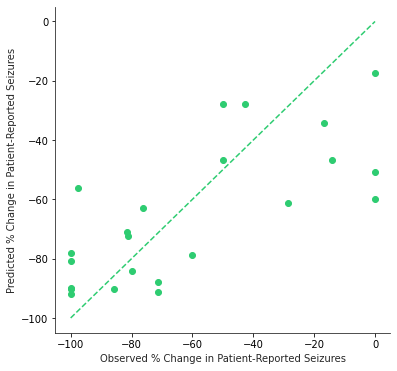

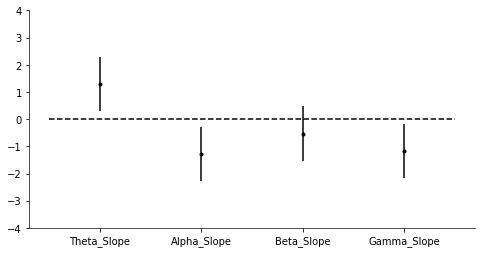

         Param         Z     p
0  Theta_Slope -1.304205  0.09
1  Alpha_Slope  1.275257  0.10
2   Beta_Slope  0.529889  0.31
3  Gamma_Slope  1.177272  0.13


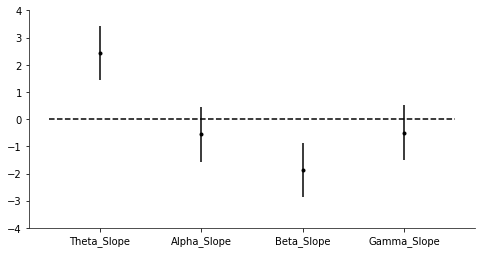

         Param         Z     p
0  Theta_Slope -2.445879  0.01
1  Alpha_Slope  0.558358  0.23
2   Beta_Slope  1.873176  0.02
3  Gamma_Slope  0.490991  0.27






-------- M --------
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


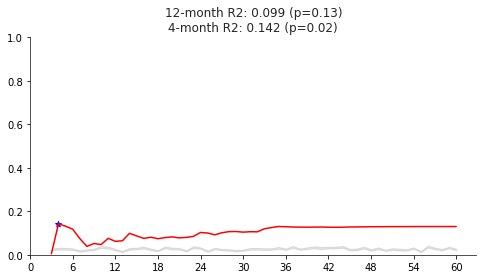

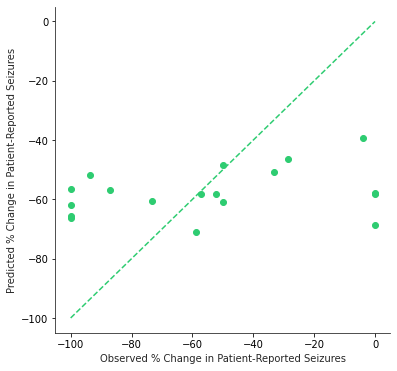

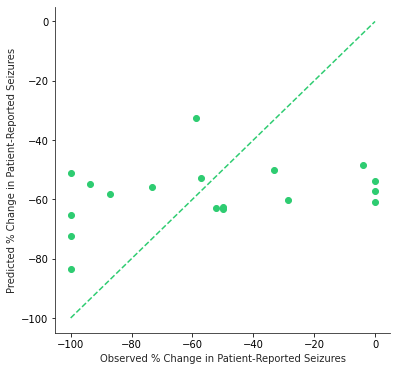

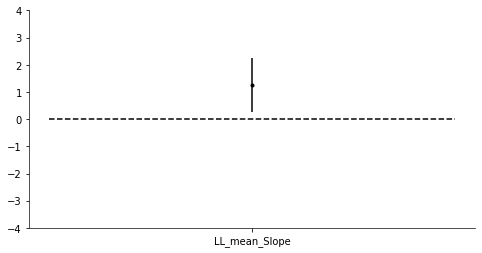

           Param         Z     p
0  LL_mean_Slope -1.257372  0.08


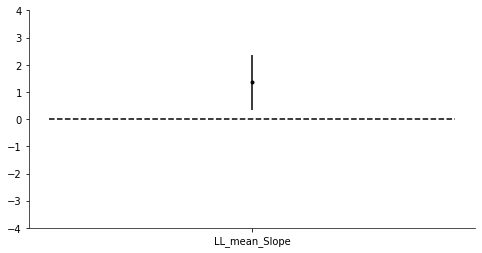

           Param         Z     p
0  LL_mean_Slope -1.355733  0.11






-------- M --------
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


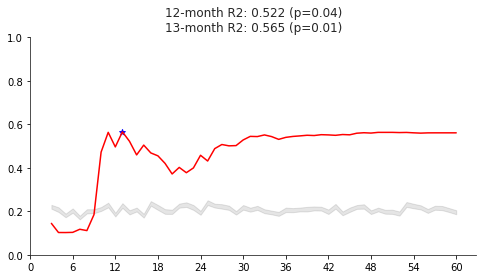

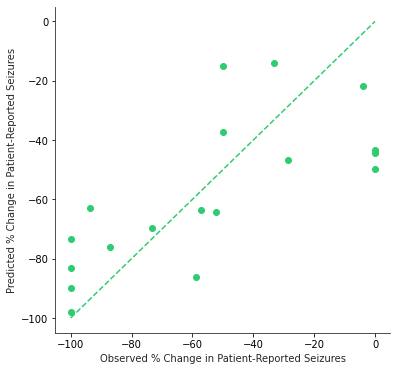

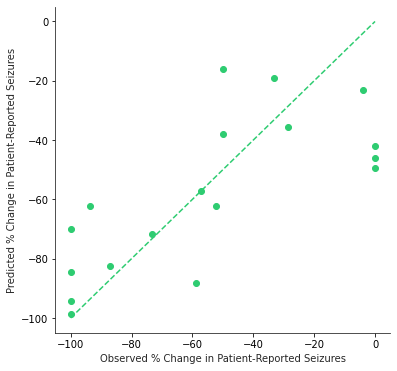

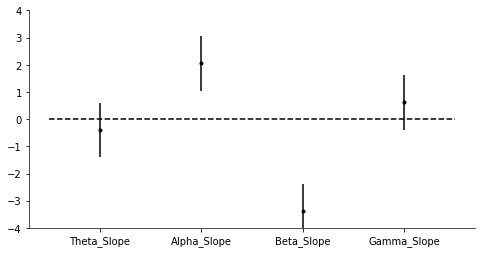

         Param         Z     p
0  Theta_Slope  0.392052  0.30
1  Alpha_Slope -2.051066  0.01
2   Beta_Slope  3.374809  0.00
3  Gamma_Slope -0.619394  0.22


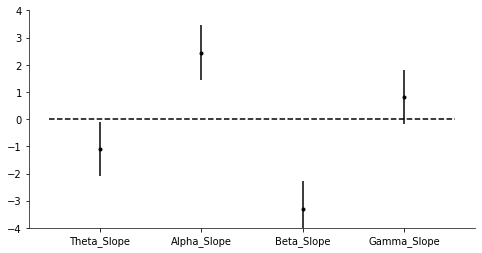

         Param         Z     p
0  Theta_Slope  1.092678  0.15
1  Alpha_Slope -2.452134  0.00
2   Beta_Slope  3.288516  0.00
3  Gamma_Slope -0.827044  0.24


In [5]:
from sklearn.model_selection import cross_val_score, cross_val_predict, permutation_test_score, LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

class statsmodel(BaseEstimator, RegressorMixin):
    def __init__(self, sm_class, formula):
        self.sm_class = sm_class
        self.formula = formula
        self.model = None
        self.result = None
 
    def fit(self,data,dummy):
        self.model = self.sm_class(self.formula, data, family=sm.families.family.Binomial())
        self.result = self.model.fit()
 
    def predict(self,X):
        return self.result.predict(X)
    
palette = sns.set_palette(["#2ecc71", "#9b59b6", "#34495e", ])   

feat_dict2 = feat_dict.copy()
feat_dict2.loc[feat_dict2['N_Vs_MT'].isin(['N']), 'N_Vs_MT'] = 'N'
for loc in ['N', 'M']: 
    for pred_type in ['IEA', 'IEA_Network']:
        print('\n\n\n\n\n\n-------- {} --------'.format(loc))        

        feat_dict3 = feat_dict2[feat_dict2['N_Vs_MT'] == loc].dropna()
        R2_all = []
        R2_all_null = []
        params_all = []
        obs_all = []
        preds_all = []
        months = []
        for month, feat_subset in feat_dict3.groupby(['Months_Elapsed']):
            print(month)
            months.append(month)

            # Clip bounds
            feat_subset['Pct_Seizure_Reduction_Last_Visit'] = (np.abs(feat_subset['Pct_Seizure_Reduction_Last_Visit'].clip(lower=-100, upper=0)) / 100)

            # Normalize features 
            if pred_type == 'IEA_Network':
                pred_feats = ['Theta_Slope',
                              'Alpha_Slope',
                              'Beta_Slope',
                              'Gamma_Slope']
            else:
                pred_feats = ['LL_mean_Slope']
            calc_R2 = lambda Y, YH: 1 - ((Y-YH)**2).sum() / ((Y-Y.mean())**2).sum()

            # create a model
            clf = statsmodel(smf.glm, 'Pct_Seizure_Reduction_Last_Visit ~ 0 + {}'.format('+'.join(pred_feats))) 

            ### Fit True model
            clf.fit(feat_subset, None)
            loocv = LeaveOneOut()
            preds_true = clf.predict(feat_subset) 
            params_true = clf.result.params.copy()
            R2_true = calc_R2(feat_subset['Pct_Seizure_Reduction_Last_Visit'], preds_true)
            R2_all.append(R2_true)
            obs_all.append(feat_subset['Pct_Seizure_Reduction_Last_Visit'])
            preds_all.append(preds_true)

            ### Fit Permuted models
            params_null = []
            R2_null = []
            feat_subset_null = feat_subset.copy()
            for rand in np.arange(100):
                feat_subset_null['Pct_Seizure_Reduction_Last_Visit'] = feat_subset_null['Pct_Seizure_Reduction_Last_Visit'].sample(frac=1).values
                clf.fit(feat_subset_null, None)
                preds_null = clf.predict(feat_subset_null)
                params_null.append(clf.result.params.copy())
                R2_null.append(calc_R2(feat_subset_null['Pct_Seizure_Reduction_Last_Visit'], preds_null))

            ### Null distribution model fit
            R2_all_null.append(np.array(R2_null))

            ### Normalize parameter fit
            params_null = pd.concat(params_null, axis=1).T
            norm_params = {'Param': [], 'Z': [], 'p': []}
            for col in params_true.index:
                pv =  np.mean(params_null[col] > params_true[col])
                val = (params_true[col] - params_null[col].mean()) / params_null[col].std()
                norm_params['Param'].append(col)
                norm_params['Z'].append(val)
                norm_params['p'].append(pv if pv < 0.5 else 1-pv)
            norm_params = pd.DataFrame.from_dict(norm_params)
            params_all.append(norm_params)
            #print(norm_params)

        ###
        r2peak = np.max(R2_all)
        r2peak_argmax = np.argmax(R2_all)
        r2peak_month = months[r2peak_argmax]
        string1 = '12-month R2: {:0.3f} (p={})'.format(R2_all[11], np.mean(R2_all_null[11] > R2_all[11]))
        string2 = '{}-month R2: {:0.3f} (p={})'.format(r2peak_month, r2peak, np.mean(R2_all_null[r2peak_month] > r2peak))

        ###
        plt.figure(figsize=(8,4))
        ax = plt.subplot(1,1,1)              
        ax.plot(months, R2_all, color='r');
        ax.fill_between(months, np.array(R2_all_null).mean(axis=1)-np.array(R2_all_null).std(axis=1)/np.sqrt(200),
                        np.array(R2_all_null).mean(axis=1)+np.array(R2_all_null).std(axis=1)/np.sqrt(200), color='k', alpha=0.1)
        ax.scatter(r2peak_month, r2peak, marker='*', color='b')
        ax.set_xticks(np.arange(0, months[-1]+6, 6))
        ax.set_ylim([0, 1])
        ax.set_title('{}\n{}'.format(string1, string2))
        plt.savefig('{}/LinRegCV.TimePerformance.{}.{}.{}.Full.svg'.format(fig_path, loc, pred_type, r2peak_month))
        plt.show()

        ###
        plt.figure(figsize=(6,6))
        ax = plt.subplot(111)
        ax.scatter(-100*obs_all[r2peak_month], -100*preds_all[r2peak_month])
        ax.plot([-100, 0], [-100, 0], linestyle='--')
        ax.set_xlim([-105, 5])
        ax.set_ylim([-105, 5])
        ax.set_xlabel('Observed % Change in Patient-Reported Seizures')
        ax.set_ylabel('Predicted % Change in Patient-Reported Seizures')
        plt.savefig('{}/LinRegCV.Fitness.{}.{}.{}.Full.svg'.format(fig_path, loc, pred_type, r2peak_month))
        plt.show()
        
        ###
        plt.figure(figsize=(6,6))
        ax = plt.subplot(111)
        ax.scatter(-100*obs_all[11], -100*preds_all[11])
        ax.plot([-100, 0], [-100, 0], linestyle='--')
        ax.set_xlim([-105, 5])
        ax.set_ylim([-105, 5])
        ax.set_xlabel('Observed % Change in Patient-Reported Seizures')
        ax.set_ylabel('Predicted % Change in Patient-Reported Seizures')
        plt.savefig('{}/LinRegCV.Fitness.{}.{}.{}.Full.svg'.format(fig_path, loc, pred_type, 11))
        plt.show()        

        ###
        coef = params_all[r2peak_month]
        plt.figure(figsize=(8,4))
        ax = plt.subplot(111)              
        ax.errorbar(np.arange(len(coef)), -1*coef.iloc[:].values[:, 1], yerr=1, fmt='.', color='k')
        ax.hlines(0, -0.5, len(coef)-0.5, color='k', linestyle='--')
        ax.set_xticks(np.arange(len(coef)))
        ax.set_xticklabels(coef.iloc[:].values[:, 0])
        ax.set_ylim([-4, 4])
        plt.savefig('{}/LinRegCV.Coefs.{}.{}.{}.Full.svg'.format(fig_path, loc, pred_type, r2peak_month))
        plt.show()
        print(coef)
        
        ###
        coef = params_all[11]
        plt.figure(figsize=(8,4))
        ax = plt.subplot(111)              
        ax.errorbar(np.arange(len(coef)), -1*coef.iloc[:].values[:, 1], yerr=1, fmt='.', color='k')
        ax.hlines(0, -0.5, len(coef)-0.5, color='k', linestyle='--')
        ax.set_xticks(np.arange(len(coef)))
        ax.set_xticklabels(coef.iloc[:].values[:, 0])
        ax.set_ylim([-4, 4])
        plt.savefig('{}/LinRegCV.Coefs.{}.{}.{}.Full.svg'.format(fig_path, loc, pred_type, 11))
        plt.show()
        print(coef)       